In [1]:
import numpy as np
import cvxpy as cp

from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
from models.LISTA import LISTA_Net
from models.L20_ISTA import L2O_ISTA
from models.TiLISTA import TiLISTA
from models.ALISTA import ALISTA

from utils.ISTA_FISTA import *
from utils.train import train
from utils.synthetic_data import SyntheticSignals

In [3]:
torch.cuda.is_available()

True

# Learned Iterative Soft Thresholding Algorithm (LISTA)

In [8]:
# Dimensions for the signal, its sparsity and its observation

n_ = 200
m_ = 150
p_ = 0.02

# Sensing matrix

A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
A_ /= torch.linalg.norm(A_, dim = 0)

# Building a training set and a test set 
train_set = SyntheticSignals(
    A = A_,
    n = n_,        
    m = m_,
    p = p_,
    SNR = 100,
    size = 4000
    )

test_set = SyntheticSignals(
    A = A_,
    n = n_,        
    m = m_,
    p = p_,
    SNR = 100,
    size = 1000
    ).set_loader()

In [10]:
torch.sqrt(train_set.var)

tensor(0.2059)

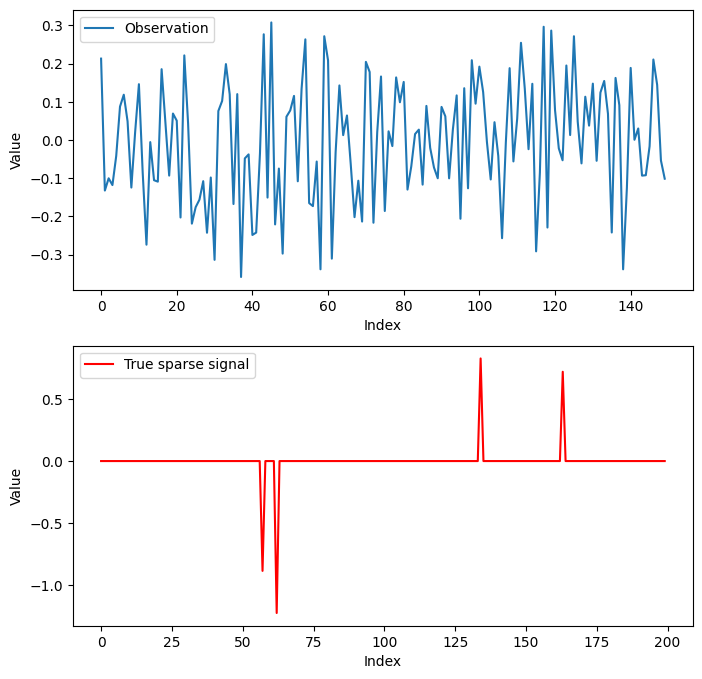

In [5]:
x_exm, s_exm =test_set.dataset.__getitem__(20)
plt.figure(figsize=(8, 8)) 
plt.subplot(2, 1, 1) 
plt.plot(x_exm, label = 'Observation' ) 
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.subplot (2, 1, 2) 
plt.plot(s_exm, label = 'True sparse signal', color='r')  
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend()
plt.show()

### Comparing ISTA and LISTA

In [13]:
M = 50
LAYERS = 5
# Dimensions for the signal, its sparsity and its observation

n_ = 200
m_ = 150
p_ = 0.02

ISTA_LOSS = np.zeros((M, 100))
FISTA_LOSS = np.zeros((M, 100))
LISTA_LOSS = np.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = 100,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = 100,
        size = 1000
        ).set_loader()
    
    model = LISTA_Net(torch.clone(A_), 0.4, 5)
    loss = train(model, train_set, test_set, num_epochs=50, verbose = False)
    
    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, 100, A_, rho = 0.4)
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, 100, A_, rho = 0.4)
    LISTA_LOSS[m,:] = model.compute_nmse_inference(test_set)

100%|██████████| 50/50 [42:41<00:00, 51.22s/it]


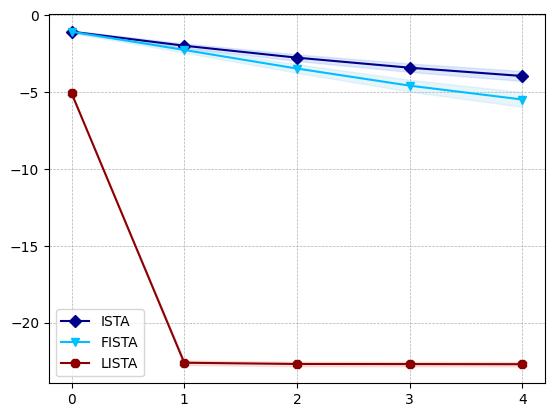

In [16]:
plt.plot(np.mean(ISTA_LOSS, axis = 0)[0:LAYERS], label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0)[0:LAYERS] - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0)[0:LAYERS], 
                np.mean(ISTA_LOSS, axis = 0)[0:LAYERS] + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0)[0:LAYERS], 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0)[0:LAYERS], label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0)[0:LAYERS] - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0)[0:LAYERS], 
                np.mean(FISTA_LOSS, axis = 0)[0:LAYERS] + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0)[0:LAYERS], 
                color='skyblue', 
                alpha=0.2)

plt.plot(np.mean(LISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(LISTA_LOSS, axis = 0) - (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    np.mean(LISTA_LOSS, axis = 0) + (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    color='lightcoral', 
                    alpha=0.2)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

# Comparing different variations of the LISTA architecture

### Noiseless case

In [4]:
M = 10
LAYERS = 16
BETA_INIT = 0.4
EPOCHS = 50
SNR = None

LISTA_LOSS = torch.zeros((M, LAYERS))
ALISTA_LOSS = torch.zeros((M, LAYERS))
TiLISTA_LOSS = torch.zeros((M, LAYERS))
L2O_ISTA_LOSS = torch.zeros((M, LAYERS))
ISTA_LOSS = torch.zeros((M, LAYERS))
FISTA_LOSS = torch.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 500
    m_ = 250
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    model1 = LISTA_Net(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model2 = ALISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model3 = TiLISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model4 = L2O_ISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model4, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    LISTA_LOSS[m,:] = model1.compute_nmse_inference(test_set)
    ALISTA_LOSS[m,:] = model2.compute_nmse_inference(test_set)
    TiLISTA_LOSS[m,:] = model3.compute_nmse_inference(test_set)
    L2O_ISTA_LOSS[m,:] = model4.compute_nmse_inference(test_set)

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)

  0%|          | 0/10 [00:00<?, ?it/s]

Linear layer initialized minimizing coherence!


 10%|█         | 1/10 [03:29<31:21, 209.10s/it]

Linear layer initialized minimizing coherence!


 20%|██        | 2/10 [06:39<26:25, 198.22s/it]

Linear layer initialized minimizing coherence!


 30%|███       | 3/10 [09:47<22:33, 193.42s/it]

Linear layer initialized minimizing coherence!


 40%|████      | 4/10 [12:56<19:09, 191.62s/it]

Linear layer initialized minimizing coherence!


 50%|█████     | 5/10 [16:03<15:51, 190.21s/it]

Linear layer initialized minimizing coherence!


 60%|██████    | 6/10 [19:11<12:36, 189.22s/it]

Linear layer initialized minimizing coherence!


 70%|███████   | 7/10 [22:16<09:24, 188.07s/it]

Linear layer initialized minimizing coherence!


 80%|████████  | 8/10 [25:26<06:17, 188.60s/it]

Linear layer initialized minimizing coherence!


 90%|█████████ | 9/10 [28:33<03:07, 187.98s/it]

Linear layer initialized minimizing coherence!


100%|██████████| 10/10 [31:40<00:00, 190.02s/it]


In [5]:
LISTA_LOSS = LISTA_LOSS.numpy()
ALISTA_LOSS = ALISTA_LOSS.numpy()
TiLISTA_LOSS = TiLISTA_LOSS.numpy()
L2O_ISTA_LOSS = L2O_ISTA_LOSS.numpy()

ISTA_LOSS = ISTA_LOSS.numpy()
FISTA_LOSS = FISTA_LOSS.numpy()

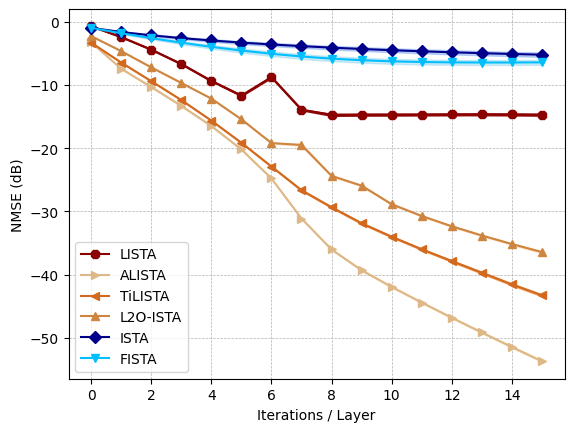

In [7]:
plt.plot(np.mean(LISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(LISTA_LOSS, axis = 0) - (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    np.mean(LISTA_LOSS, axis = 0) + (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.9)

plt.plot(np.mean(ALISTA_LOSS, axis = 0), label='ALISTA', color='burlywood', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(ALISTA_LOSS, axis = 0) - (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    np.mean(ALISTA_LOSS, axis = 0) + (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    color='wheat', 
                    alpha=0.9)

plt.plot(np.mean(TiLISTA_LOSS, axis = 0), label='TiLISTA', color='chocolate', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLISTA_LOSS, axis = 0) - (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    np.mean(TiLISTA_LOSS, axis = 0) + (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    color='sandybrown', 
                    alpha=0.9)

plt.plot(np.mean(L2O_ISTA_LOSS, axis = 0), label='L2O-ISTA', color='peru', marker = '^')
plt.fill_between(range(LAYERS), 
                    np.mean(L2O_ISTA_LOSS, axis = 0) - (2/np.sqrt(L2O_ISTA_LOSS.shape[1])) * np.std(L2O_ISTA_LOSS, axis = 0), 
                    np.mean(L2O_ISTA_LOSS, axis = 0) + (2/np.sqrt(L2O_ISTA_LOSS.shape[1])) * np.std(L2O_ISTA_LOSS, axis = 0), 
                    color='peachpuff', 
                    alpha=0.9)

plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.4)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.4)

plt.xticks(range(LAYERS))

plt.ylabel('NMSE (dB)')
plt.xlabel('Iterations / Layer')

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

### 30db gain 

In [4]:
M = 1
LAYERS = 16
BETA_INIT = 0.4
EPOCHS = 50
SNR = 1000

LISTA_LOSS = torch.zeros((M, LAYERS))
ALISTA_LOSS = torch.zeros((M, LAYERS))
TiLISTA_LOSS = torch.zeros((M, LAYERS))
L2O_ISTA_LOSS = torch.zeros((M, LAYERS))
ISTA_LOSS = torch.zeros((M, LAYERS))
FISTA_LOSS = torch.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 500
    m_ = 250
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    model1 = LISTA_Net(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model2 = ALISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model3 = TiLISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    LISTA_LOSS[m,:] = model1.compute_nmse_inference(test_set)
    ALISTA_LOSS[m,:] = model2.compute_nmse_inference(test_set)
    TiLISTA_LOSS[m,:] = model3.compute_nmse_inference(test_set)
    #L2O_ISTA_LOSS[m,:] = model4.compute_nmse_inference(test_set)

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)

  0%|          | 0/1 [00:00<?, ?it/s]

Linear layer initialized minimizing coherence!


100%|██████████| 1/1 [03:06<00:00, 186.38s/it]


In [5]:
LISTA_LOSS = LISTA_LOSS.cpu().numpy()
ALISTA_LOSS = ALISTA_LOSS.cpu().numpy()
TiLISTA_LOSS = TiLISTA_LOSS.cpu().numpy()


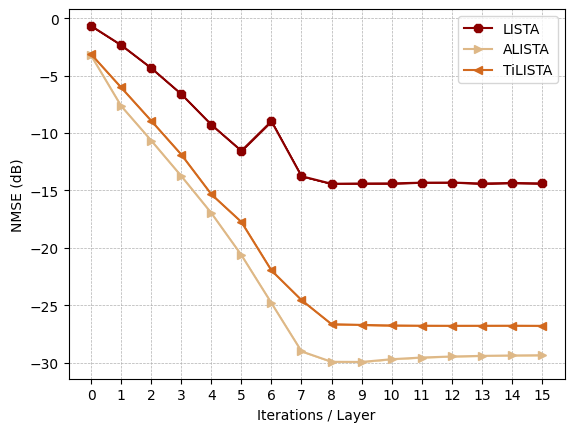

In [6]:
plt.plot(np.mean(LISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(LISTA_LOSS, axis = 0) - (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    np.mean(LISTA_LOSS, axis = 0) + (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.9)

plt.plot(np.mean(ALISTA_LOSS, axis = 0), label='ALISTA', color='burlywood', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(ALISTA_LOSS, axis = 0) - (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    np.mean(ALISTA_LOSS, axis = 0) + (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    color='wheat', 
                    alpha=0.9)

plt.plot(np.mean(TiLISTA_LOSS, axis = 0), label='TiLISTA', color='chocolate', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLISTA_LOSS, axis = 0) - (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    np.mean(TiLISTA_LOSS, axis = 0) + (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    color='sandybrown', 
                    alpha=0.9)

plt.xticks(range(LAYERS))

plt.ylabel('NMSE (dB)')
plt.xlabel('Iterations / Layer')


plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

In [ ]:
plt.plot(np.mean(LISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(LISTA_LOSS, axis = 0) - (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    np.mean(LISTA_LOSS, axis = 0) + (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.9)

plt.plot(np.mean(ALISTA_LOSS, axis = 0), label='ALISTA', color='burlywood', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(ALISTA_LOSS, axis = 0) - (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    np.mean(ALISTA_LOSS, axis = 0) + (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    color='wheat', 
                    alpha=0.9)

plt.plot(np.mean(TiLISTA_LOSS, axis = 0), label='TiLISTA', color='chocolate', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLISTA_LOSS, axis = 0) - (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    np.mean(TiLISTA_LOSS, axis = 0) + (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    color='sandybrown', 
                    alpha=0.9)

plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.4)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.4)

plt.xticks(range(LAYERS))

plt.ylabel('NMSE (dB)')
plt.xlabel('Iterations / Layer')


plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

In [10]:
LISTA_LOSS = LISTA_LOSS.numpy()
ALISTA_LOSS = ALISTA_LOSS.numpy()
TiLISTA_LOSS = TiLISTA_LOSS.numpy()
L2O_ISTA_LOSS = L2O_ISTA_LOSS.numpy()

ISTA_LOSS = ISTA_LOSS.numpy()
FISTA_LOSS = FISTA_LOSS.numpy()

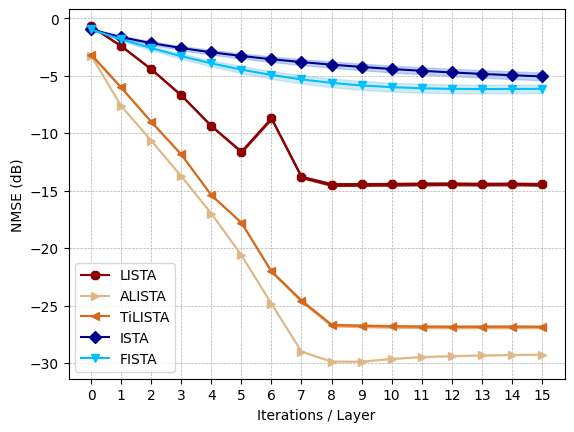

In [20]:
plt.plot(np.mean(LISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(LISTA_LOSS, axis = 0) - (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    np.mean(LISTA_LOSS, axis = 0) + (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.9)

plt.plot(np.mean(ALISTA_LOSS, axis = 0), label='ALISTA', color='burlywood', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(ALISTA_LOSS, axis = 0) - (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    np.mean(ALISTA_LOSS, axis = 0) + (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    color='wheat', 
                    alpha=0.9)

plt.plot(np.mean(TiLISTA_LOSS, axis = 0), label='TiLISTA', color='chocolate', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLISTA_LOSS, axis = 0) - (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    np.mean(TiLISTA_LOSS, axis = 0) + (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    color='sandybrown', 
                    alpha=0.9)

plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.4)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.4)

plt.xticks(range(LAYERS))

plt.ylabel('NMSE (dB)')
plt.xlabel('Iterations / Layer')


plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()